# The `opencadd.databases.klifs` module

The `opencadd.databases.klifs` module offers to interact with KLIFS data 

- __locally__ ([KLIFS data download](https://klifs.vu-compmedchem.nl/search.php)) and
- __remote__ ([KLIFS swagger API](https://klifs.vu-compmedchem.nl/swagger/))  

following the same API in its `local` and `remote` modules.

In the following, the API will be demonstrated in parallel for local and remote access for the following sources of information (classes in `local` and `remote` modules):

- `Kinases`: Details on kinases in KLIFS
- `Ligands`: Details on ligands in KLIFS
- `Structures`  Details on structures in KLIFS (extracted from the PDB)
- `Bioactivities` (accessible only remotely): Details on bioactivities in KLIFS (extracted from ChEMBL)
- `Interactions`: Details on kinase-ligand interactions in KLIFS
- `Pockets`: Details on kinase pockets in KLIFS
- `Coordinates`: Coordinates for complexes, ligands, pockets, proteins, and water in KLIFS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from pathlib import Path

from bravado_core.exception import SwaggerMappingError
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', 50)
logger = logging.getLogger("opencadd")
logger.setLevel(logging.INFO)

## Set up remote and local session

From the `api` module, import the session setup functions `setup_remote()` and `setup_local()`.

In [4]:
from opencadd.databases.klifs import setup_local, setup_remote

### Remote session

Set up a __remote session__ to work with remote KLIFS data (access via the KLIFS swagger API).

In [5]:
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [6]:
remote._client

SwaggerClient(https://dev.klifs.net/api_v2)

### Local session

Set up a __local session__ to work with local KLIFS data (access to a KLIFS download folder).

In [7]:
local = setup_local("../../opencadd/tests/data/klifs")

INFO:opencadd.databases.klifs.api:Set up local session...
INFO:opencadd.databases.klifs.local:Load overview.csv...
INFO:opencadd.databases.klifs.local:Load KLIFS_export.csv...
INFO:opencadd.databases.klifs.local:Merge both csv files...
INFO:opencadd.databases.klifs.local:Add paths to coordinate folders to structures...
INFO:opencadd.databases.klifs.local:Add KLIFS IDs to structures (uses remote since not available locally!)...
INFO:opencadd.databases.klifs.api:Local session is ready!


The `setup_local` function will initialize a __database__ (a `pandas.DataFrame`), describing the metadata of structures contained in the KLIFS download. 

In [8]:
local._database

,species.klifs,structure.pdb_id,structure.alternate_model,structure.chain,ligand.expo_id,ligand_allosteric.expo_id,structure.rmsd1,structure.rmsd2,structure.qualityscore,structure.pocket,structure.resolution,structure.missing_residues,structure.missing_atoms,interaction.fingerprint,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,kinase.names,kinase.gene_name,kinase.klifs_name,kinase.family,kinase.group,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.filepath,structure.klifs_id,kinase.klifs_id
0,Human,3sxr,-,A,1N1,-,0.839,1.967,6.4,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.40,4,0,0000000000000010000001000000000000000000000000...,0,0,1,1,0,0,0,0,0,0,0,0,[BMX],BMX,BMX,Tec,TK,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,HUMAN/BMX/3sxr_chainA,3482,472
1,Human,6uuo,-,A,QH1,-,0.806,2.028,5.2,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,3.29,7,61,0000000000000000000000000000000000000000000000...,0,0,1,1,1,1,0,0,0,0,0,0,[BRAF],BRAF,BRAF,RAF,TKL,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,HUMAN/BRAF/6uuo_chainA,12347,509
2,Mouse,1fpu,-,A,PRC,-,0.925,2.319,8.8,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,0,8,0000000000000010000000000000000000000000000000...,0,0,1,1,0,0,0,1,0,0,0,0,"[Abl1, ABL1]",Abl1,ABL1,Abl,TK,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,MOUSE/ABL1/1fpu_chainA,5728,532
3,Mouse,1fpu,-,B,PRC,-,0.925,2.329,9.2,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,0,4,0000000000000010000000000000000000000000000000...,0,0,0,1,0,0,0,1,0,0,0,0,"[Abl1, ABL1]",Abl1,ABL1,Abl,TK,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,MOUSE/ABL1/1fpu_chainB,5705,532


### Access information

Different sources of information are accessible via (instances of classes introduced earlier, which are initialized upon session setup):

- `local.kinases` or `remote.kinases`
- `local.ligands` or `remote.ligands`
- `local.structures` or `remote.structures`
- `local.bioactivities` or `remote.bioactivities`
- `local.interactions` or `remote.interactions`
- `local.pockets` or `remote.pockets`
- `local.coordinates` or `remote.coordinates`

|                           | kinases | ligands | structures | bioactivities | interactions | pockets |
|:--------------------------| -  | -  | -  | -       | -  | -  |
| __by_kinase_klifs_id__    | x* | x* | x* |         | x  |    | 
| __by_kinase_name__        | x* | x  | x  |         |    |    |
| __by_ligand_klifs_id__    |    | x* | x  | x\* \** | x  |    |
| __by_ligand_expo_id__     |    | x  | x  | x\* \** |    |    |
| __by_structure_klifs_id__ |    |    | x* |         | x* | x* |
| __by_structure_pdb_id__   |    |    | x* |         |    |    |

 \* Direct use of KLIFS Swagger API.
 
 \** KLIFS Swagger API allows only ONE input value.

## Kinases

Explore access to kinase information.

### All kinase groups

__Remote__

In [9]:
remote.kinases.all_kinase_groups()

,kinase.group
0,AGC
1,CAMK
...,...
6,TK
7,TKL


__Local__

__Note__: When querying all kinase groups locally, "all" refers to "all kinase groups that are locally available" and hence does not represent all existing kinase groups.

In [10]:
local.kinases.all_kinase_groups()

,kinase.group
0,TK
1,TKL


### All kinase families (in a kinase group)

__Remote__

In [11]:
remote.kinases.all_kinase_families()

,kinase.family
0,A6
1,ABC1
...,...
142,Wnk
143,YANK


In [12]:
remote.kinases.all_kinase_families(group="TK")

,kinase.family
0,ALK
1,Abl
...,...
29,Trk
30,VEGFR


In [13]:
try:
    remote.kinases.all_kinase_families(group="XXX")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: A provided group does not exist.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

__Note__: When querying all kinase families locally, "all" refers to "all kinase families that are locally available" and hence does not represent all existing kinase families.

In [14]:
local.kinases.all_kinase_families()

,kinase.family
0,Tec
1,RAF
2,Abl


In [15]:
local.kinases.all_kinase_families(group="TK")

,kinase.family
0,Tec
1,Abl


In [16]:
try:
    local.kinases.all_kinase_families("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### All kinase names

__Remote__

In [17]:
remote.kinases.all_kinases()

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,529,A6,0,,None,Mouse
1,530,A6r,0,,None,Mouse
...,...,...,...,...,...,...
1125,1062,ZAP70,zeta-chain (TCR) associated protein kinase,Zap70,None,Mouse
1126,471,ZAP70,zeta chain of T cell receptor associated prote...,ZAP70,None,Human


In [18]:
remote.kinases.all_kinases(group="TK", family="Tec", species="Mouse")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,574,BMX,BMX non-receptor tyrosine kinase,Bmx,None,Mouse
1,583,BTK,Bruton agammaglobulinemia tyrosine kinase,Btk,None,Mouse
2,739,ITK,IL2 inducible T cell kinase,Itk,None,Mouse
3,1008,TEC,tec protein tyrosine kinase,Tec,None,Mouse
4,1039,TXK,TXK tyrosine kinase,Txk,None,Mouse


In [19]:
try:
    remote.kinases.all_kinases(group="XXX")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: A provided group does not exist.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

__Note__: When querying all kinase names locally, "all" refers to "all kinase names that are locally available" and hence does not represent all existing kinase names.

In [20]:
local.kinases.all_kinases(family="Tec")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,472,BMX,None,BMX,None,Human


In [21]:
local.kinases.all_kinases(family="Abl", species="Mouse")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,532,ABL1,None,Abl1,None,Mouse


In [22]:
try:
    local.kinases.all_kinases(group="XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Kinase by kinase KLIFS ID

__Remote__

In [23]:
remote.kinases.by_kinase_klifs_id(1)

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,1,AKT1,v-akt murine thymoma viral oncogene homolog 1,AKT1,Akt,AGC,,Human,P31749,1479,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...


In [24]:
remote.kinases.by_kinase_klifs_id([1,2,10000])

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,1,AKT1,v-akt murine thymoma viral oncogene homolog 1,AKT1,Akt,AGC,,Human,P31749,1479,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...
1,2,AKT2,v-akt murine thymoma viral oncogene homolog 2,AKT2,Akt,AGC,,Human,P31751,1480,KLLGKGTFGKVILYAMKILHTVTESRVLQNTRPFLTALKYACFVME...


In [25]:
try:
    remote.kinases.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [26]:
local.kinases.by_kinase_klifs_id(472)

Index(['species.klifs', 'structure.pdb_id', 'structure.alternate_model',
       'structure.chain', 'ligand.expo_id', 'ligand_allosteric.expo_id',
       'structure.rmsd1', 'structure.rmsd2', 'structure.qualityscore',
       'structure.pocket', 'structure.resolution',
       'structure.missing_residues', 'structure.missing_atoms',
       'interaction.fingerprint', 'structure.fp_i', 'structure.fp_ii',
       'structure.bp_i_a', 'structure.bp_i_b', 'structure.bp_ii_in',
       'structure.bp_ii_a_in', 'structure.bp_ii_b_in', 'structure.bp_ii_out',
       'structure.bp_ii_b', 'structure.bp_iii', 'structure.bp_iv',
       'structure.bp_v', 'kinase.names', 'kinase.gene_name',
       'kinase.klifs_name', 'kinase.family', 'kinase.group', 'ligand.name',
       'ligand_allosteric.name', 'structure.dfg', 'structure.ac_helix',
       'structure.filepath', 'structure.klifs_id', 'kinase.klifs_id'],
      dtype='object')


,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,None,BMX,Tec,TK,None,Human,None,None,None


In [27]:
local.kinases.by_kinase_klifs_id([472, 509, 10000])

Index(['species.klifs', 'structure.pdb_id', 'structure.alternate_model',
       'structure.chain', 'ligand.expo_id', 'ligand_allosteric.expo_id',
       'structure.rmsd1', 'structure.rmsd2', 'structure.qualityscore',
       'structure.pocket', 'structure.resolution',
       'structure.missing_residues', 'structure.missing_atoms',
       'interaction.fingerprint', 'structure.fp_i', 'structure.fp_ii',
       'structure.bp_i_a', 'structure.bp_i_b', 'structure.bp_ii_in',
       'structure.bp_ii_a_in', 'structure.bp_ii_b_in', 'structure.bp_ii_out',
       'structure.bp_ii_b', 'structure.bp_iii', 'structure.bp_iv',
       'structure.bp_v', 'kinase.names', 'kinase.gene_name',
       'kinase.klifs_name', 'kinase.family', 'kinase.group', 'ligand.name',
       'ligand_allosteric.name', 'structure.dfg', 'structure.ac_helix',
       'structure.filepath', 'structure.klifs_id', 'kinase.klifs_id'],
      dtype='object')


,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,None,BMX,Tec,TK,None,Human,None,None,None
1,509,BRAF,None,BRAF,RAF,TKL,None,Human,None,None,None


In [28]:
try:
    local.kinases.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Index(['species.klifs', 'structure.pdb_id', 'structure.alternate_model',
       'structure.chain', 'ligand.expo_id', 'ligand_allosteric.expo_id',
       'structure.rmsd1', 'structure.rmsd2', 'structure.qualityscore',
       'structure.pocket', 'structure.resolution',
       'structure.missing_residues', 'structure.missing_atoms',
       'interaction.fingerprint', 'structure.fp_i', 'structure.fp_ii',
       'structure.bp_i_a', 'structure.bp_i_b', 'structure.bp_ii_in',
       'structure.bp_ii_a_in', 'structure.bp_ii_b_in', 'structure.bp_ii_out',
       'structure.bp_ii_b', 'structure.bp_iii', 'structure.bp_iv',
       'structure.bp_v', 'kinase.names', 'kinase.gene_name',
       'kinase.klifs_name', 'kinase.family', 'kinase.group', 'ligand.name',
       'ligand_allosteric.name', 'structure.dfg', 'structure.ac_helix',
       'structure.filepath', 'structure.klifs_id', 'kinase.klifs_id'],
      dtype='object')
Input values yield no results.


### Kinase by kinase name (and species)

__Remote__

In [29]:
remote.kinases.by_kinase_name("BMX")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,574,BMX,BMX non-receptor tyrosine kinase,Bmx,Tec,TK,,Mouse,P97504,0,KELGNGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,472,BMX,BMX non-receptor tyrosine kinase,BMX,Tec,TK,,Human,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...


In [30]:
remote.kinases.by_kinase_name("Bmx")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,574,BMX,BMX non-receptor tyrosine kinase,Bmx,Tec,TK,,Mouse,P97504,0,KELGNGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,472,BMX,BMX non-receptor tyrosine kinase,BMX,Tec,TK,,Human,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...


In [31]:
try:
    remote.kinases.by_kinase_name("BMX", species="Dog")
except SwaggerMappingError as e:
    print(e)

ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for BMX: Expected type to be dict for value [400, 'KLIFS error: The provided species does not exist. '] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.



Input values yield no results.


In [32]:
remote.kinases.by_kinase_name(["BMX", "BRAF", "XXX"], species="Human")

ERROR:opencadd.databases.klifs.core:There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for XXX: Expected type to be dict for value [400, 'KLIFS error: An unknown kinase name was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,BMX non-receptor tyrosine kinase,BMX,Tec,TK,,Human,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,509,BRAF,"B-Raf proto-oncogene, serine/threonine kinase",BRAF,RAF,TKL,RAF,Human,P15056,1943,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...


__Local__

In [33]:
local.kinases.by_kinase_name("BMX")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,None,BMX,Tec,TK,None,Human,None,None,None


In [34]:
try:
    local.kinases.by_kinase_name("BMX", species="Dog")
except ValueError as e:
    print(e)

Input values yield no results.


In [35]:
local.kinases.by_kinase_name(["BMX", "BRAF", "XXX"], species="Human")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.class,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,None,BMX,Tec,TK,None,Human,None,None,None
1,509,BRAF,None,BRAF,RAF,TKL,None,Human,None,None,None


## Ligands

Explore access to ligand information.

### All ligands

__Remote__

In [36]:
remote.ligands.all_ligands()

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,1,IHZ,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,FC(F)(F)c1cc(NC(=O)c2cc(Nc3cncc(c3)C(=O)N)c(cc...,SAAYRHKJHDIDPH-UHFFFAOYSA-N
1,2,477,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",S1C=2C(=NNC2C=C1C(F)F)C=3Nc4c(ccc(c4)C(O)(CC)C...,CQZZZUNOWZUNNG-UHFFFAOYSA-N
...,...,...,...,...,...
3559,3849,R6K,"2-azanyl-~{N}-[(1~{S},2~{S})-2-[[4-[4-[(4-meth...",CN1CCN(CC1)Cc2ccc(cc2)c3ccc(CO[C@H]4CCC[C@@H]4...,GTVWQFJFCAUNFY-ACHIHNKUSA-N
3560,3850,57N,"(2R)-2-(1-oxo-1,3-dihydro-2H-isoindol-2-yl)-2-...",S1C(=NC=C1)NC(=O)[C@H](N2C(=O)c3c(cccc3)C2)c4c...,InChI not available


__Local__

__Note__: When querying all ligands locally, "all" refers to "all ligands that are locally available" and hence does not represent all existing ligands.

In [37]:
local.ligands.all_ligands()

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,None,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,None,None
1,None,QH1,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,None,None
2,None,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,None,None


Locally, information on SMILES and InChI keys is not available. Also no ligand ID, but maybe the KLIFS maintainers can change that?

### Ligands from kinase KLIFS ID(s)

__Remote__

In [38]:
remote.ligands.by_kinase_klifs_id(472)

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,472
1,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472
2,3716,H88,~{N}-[2-methyl-5-[8-[4-(methylsulfonylamino)ph...,S(=O)(=O)(Nc1ccc(c2cc3ncc4c(N(c5cc(NC(=O)CCO)c...,InChI not available,472


In [39]:
remote.ligands.by_kinase_klifs_id([472, 509, 10000])

ERROR:opencadd.databases.klifs.core:There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,472
1,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472
...,...,...,...,...,...,...
64,3715,QH1,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,S(O)(O)(Nc1c(F)c(N2c3c(nc(N(C4C=CN(C(=O)C)C=C4...,InChI not available,509
65,3829,E7M,"3-[(imidazo[1,2-b]pyridazin-3-yl)ethynyl]-4-me...",FC(F)(F)c1c(ccc(NC(=O)c2cc(C#CC=3N4N=CC=CC4=NC...,InChI not available,509


In [40]:
try:
    remote.ligands.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.



Input values yield no results.


__Local__

In [41]:
local.ligands.by_kinase_klifs_id(472)

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,None,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,None,None,472


In [42]:
local.ligands.by_kinase_klifs_id([472, 509, 10000])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,None,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,None,None,472
1,None,QH1,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,None,None,509


In [43]:
try:
    local.ligands.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


### Ligands from kinase name(s)

__Remote__

In [44]:
remote.ligands.by_kinase_name(["ABL1", "BMX"])

INFO:opencadd.databases.klifs.remote:Fetch kinase KLIFS IDs for input kinase names...


INFO:opencadd.databases.klifs.remote:Fetch ligands based on these KLIFS IDs...


ERROR:opencadd.databases.klifs.core:There was (were) 1/4 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 574: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query),kinase.klifs_name (query),kinase.gene_name (query),species.klifs (query)
0,26,ADP,ADENOSINE-5&apos;-DIPHOSPHATE,P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c...,XTWYTFMLZFPYCI-KQYNXXCUSA-N,392,ABL1,ABL1,Human
1,38,AGS,PHOSPHOTHIOPHOSPHORIC ACID-ADENYLATE ESTER,S=P(OP(=O)(OP(=O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c...,NLTUCYMLOPLUHL-KQYNXXCUSA-N,392,ABL1,ABL1,Human
...,...,...,...,...,...,...,...,...,...
43,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472,BMX,BMX,Human
44,3716,H88,~{N}-[2-methyl-5-[8-[4-(methylsulfonylamino)ph...,S(=O)(=O)(Nc1ccc(c2cc3ncc4c(N(c5cc(NC(=O)CCO)c...,InChI not available,472,BMX,BMX,Human


In [45]:
try:
    remote.ligands.by_kinase_name("XXX")
except SwaggerMappingError as e:
    print(e)

INFO:opencadd.databases.klifs.remote:Fetch kinase KLIFS IDs for input kinase names...


ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for XXX: Expected type to be dict for value [400, 'KLIFS error: An unknown kinase name was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.



Input values yield no results.


__Local__

In [46]:
local.ligands.by_kinase_name(["ABL1", "BMX"])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_name (query),kinase.gene_name (query),species.klifs (query)
0,None,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,None,None,BMX,BMX,Human
1,None,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,None,None,ABL1,Abl1,Mouse


In [47]:
try:
    local.ligands.by_kinase_name("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Ligands from ligand KLIFS ID(s)

__Remote__

In [48]:
remote.ligands.by_ligand_klifs_id([100, 200, 10000])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,100,KSA,K-252A,O=C(OC)[C@]1(O)[C@@]2(O[C@@H](N3c4c5N2c6c(c5c7...,KOZFSFOOLUUIGY-SOLYNIJKSA-N
1,200,TSK,3-(5-fluoro-6-iodo-1-methyl-1H-indol-3-yl)-4-(...,Ic1c(F)cc2c(N(C=C2C=3C(=O)NC(=O)C3C=4c5c(OC4)c...,JBKILIGSDAQHSL-UHFFFAOYSA-N


In [49]:
try:
    remote.ligands.by_ligand_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Ligands from ligand expo ID(s)

__Remote__

In [50]:
remote.ligands.by_ligand_expo_id(["STI", "STU", "XXX"])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,28,STU,STAUROSPORINE,O=C1NCc2c3c4N(c5c3cccc5)[C@]6(O[C@@H](N7c4c(c8...,HKSZLNNOFSGOKW-FYTWVXJKSA-N
1,48,STI,4-(4-METHYL-PIPERAZIN-1-YLMETHYL)-N-[4-METHYL-...,O=C(Nc1cc(Nc2nc(c3cnccc3)ccn2)c(cc1)C)c4ccc(cc...,KTUFNOKKBVMGRW-UHFFFAOYSA-N


In [51]:
try:
    remote.ligands.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [52]:
local.ligands.by_ligand_expo_id(["STI", "STU", "PRC"])  # TODO why do STI STU work but XXX does not?

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,None,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,None,None


In [53]:
try:
    local.ligands.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


## Structures

Explore access to structure information.

### All structures

__Remote__

In [54]:
remote.structures.all_structures()

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,10882,6npz,B,A,Human,1,AKT1,None,None,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,-,-,0,0,None,None,in,in,2.12,8.0,0,0,0.778,2.094,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,18.3634,62.7273,65.0817,None
1,10915,6hhh,-,A,Human,1,AKT1,None,None,KLLGKGTFGKVILYAMKIL______RVLQNSRPFLTALKYSCFVME...,G4Q,-,3327,0,None,None,out,na,2.70,4.8,6,0,0.941,2.423,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,19.7287,65.6581,57.7636,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11657,9070,6bq1,-,A,Human,1096,PI4KA,None,None,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,E4S,-,2974,0,None,None,in,in,NaN,6.8,2,0,1.704,2.676,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,18.3243,58.9635,131.1870,None
11658,9069,6bq1,-,E,Human,1096,PI4KA,None,None,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,E4S,-,2974,0,None,None,in,in,NaN,6.8,2,0,1.699,2.670,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,18.1686,58.6454,136.5030,None


__Local__

__Note__: When querying all structures locally, "all" refers to "all structures that are locally available" and hence does not represent all existing structures.

In [55]:
local.structures.all_structures()

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,3482,3sxr,-,A,Human,472,BMX,Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,None,None,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.40,6.4,4,0,0.839,1.967,None,None,None,0,0,1,1,0,0,0,0,0,0,0,0,None,None,None,HUMAN/BMX/3sxr_chainA
1,12347,6uuo,-,A,Human,509,BRAF,RAF,TKL,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,None,None,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,3.29,5.2,7,61,0.806,2.028,None,None,None,0,0,1,1,1,1,0,0,0,0,0,0,None,None,None,HUMAN/BRAF/6uuo_chainA
2,5728,1fpu,-,A,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.40,8.8,0,8,0.925,2.319,None,None,None,0,0,1,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainA
3,5705,1fpu,-,B,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.40,9.2,0,4,0.925,2.329,None,None,None,0,0,0,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainB


### Structures from structure KLIFS ID(s)

__Remote__

In [56]:
remote.structures.by_structure_klifs_id([12347, 100000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,12347,6uuo,-,A,Human,509,BRAF,None,None,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,3715,0,None,None,in,out-like,3.29,5.2,7,61,0.806,2.028,True,True,True,False,False,True,True,True,True,False,False,False,False,False,False,0.0,0.0,0.0,None


In [57]:
try: 
    remote.structures.by_structure_klifs_id(100000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown ligand ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [58]:
local.structures.by_structure_klifs_id(12347)

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,12347,6uuo,-,A,Human,509,BRAF,RAF,TKL,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,None,None,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,3.29,5.2,7,61,0.806,2.028,None,None,None,0,0,1,1,1,1,0,0,0,0,0,0,None,None,None,HUMAN/BRAF/6uuo_chainA


In [59]:
local.structures.by_structure_klifs_id(12347).shape

(1, 43)

In [60]:
try: 
    local.structures.by_structure_klifs_id(100000)
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from ligand KLIFS ID(s)

__Remote__

In [61]:
remote.structures.by_ligand_klifs_id([100, 200, 10000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,8733,5m5a,B,A,Human,128,MELK,None,None,ETIGTGGFAKVKLVAIKIMRIKTEIEALKNLRQHICQLYHVFMVLE...,KSA,-,100,0,None,None,in,in,1.9,8.0,0,0,0.775,2.083,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,14.9753,51.0238,60.3786,None
1,8735,5m5a,A,A,Human,128,MELK,None,None,ETIGTGGFAKVKLVAIKIMRIKTEIEALKNLRQHICQLYHVFMVLE...,KSA,-,100,0,None,None,in,in,1.9,8.0,0,0,0.775,2.083,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,14.9753,51.0238,60.3786,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,3317,3eqf,-,A,Human,383,MAP2K1,None,None,SELGAGNGGVVFKMARKLIQIIRELQVLHECNPYIVGFYGASICME...,KSA,-,100,0,None,None,in,out,2.7,8.0,0,0,0.816,2.199,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,15.1080,51.2885,69.3669,None
13,2991,1r0p,-,A,Human,446,MET,None,None,EVIGRGHFGCVYHCAVKSLQFLTEGIIMKDFSPNVLSLLGILVVLP...,KSA,-,100,0,None,None,in,out,1.8,8.0,0,0,0.848,2.189,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,20.0054,66.3494,48.1602,None


In [62]:
try:
    remote.structures.by_ligand_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Structures from kinase KLIFS ID(s)

__Remote__

In [63]:
remote.structures.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,3481,3sxr,-,B,Human,472,BMX,None,None,KEL______VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,281,0,None,None,out-like,in,2.4,5.6,6,0,0.839,1.946,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
1,12348,6i99,-,A,Human,472,BMX,None,None,KELGSGQFGVVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,H88,-,3716,0,None,None,out-like,out-like,2.0,8.0,0,0,0.831,2.116,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,16.2983,55.0138,61.0275,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,3126,4pp7,-,B,Human,509,BRAF,None,None,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,2VX,-,945,0,None,None,in,out,3.4,8.0,0,0,0.813,2.142,True,True,True,True,False,True,True,True,False,False,False,False,False,False,False,17.1234,55.5483,31.8510,None
197,3095,3d4q,-,A,Human,509,BRAF,None,None,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,SM5,-,249,0,None,None,in,in,2.8,8.0,0,0,0.779,2.120,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,14.7287,49.4656,72.6044,None


In [64]:
try:
    remote.structures.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [65]:
local.structures.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,3482,3sxr,-,A,Human,472,BMX,Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,None,None,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.40,6.4,4,0,0.839,1.967,None,None,None,0,0,1,1,0,0,0,0,0,0,0,0,None,None,None,HUMAN/BMX/3sxr_chainA
1,12347,6uuo,-,A,Human,509,BRAF,RAF,TKL,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,None,None,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,3.29,5.2,7,61,0.806,2.028,None,None,None,0,0,1,1,1,1,0,0,0,0,0,0,None,None,None,HUMAN/BRAF/6uuo_chainA


In [66]:
try:
    local.structures.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from structure PDB ID(s)

__Remote__

In [67]:
remote.structures.by_structure_pdb_id(["3sxr", "1fpu", "xxxx"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,5705,1fpu,-,B,Mouse,532,ABL1,None,None,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,1793,0,None,None,out,out,2.4,9.2,0,4,0.925,2.329,True,True,True,False,False,False,True,False,False,False,True,False,False,False,False,15.3329,51.0939,49.2289,None
1,5728,1fpu,-,A,Mouse,532,ABL1,None,None,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,1793,0,None,None,out,out,2.4,8.8,0,8,0.925,2.319,True,True,True,False,False,True,True,False,False,False,True,False,False,False,False,16.1554,54.1402,48.7414,None
2,3481,3sxr,-,B,Human,472,BMX,None,None,KEL______VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,281,0,None,None,out-like,in,2.4,5.6,6,0,0.839,1.946,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
3,3482,3sxr,-,A,Human,472,BMX,None,None,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,281,0,None,None,out-like,in,2.4,6.4,4,0,0.839,1.967,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None


In [68]:
try:
    remote.structures.by_structure_pdb_id("xxxx")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown ligand ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [69]:
local.structures.by_structure_pdb_id(["3sxr", "1fpu", "xxxx"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,3482,3sxr,-,A,Human,472,BMX,Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,None,None,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.4,6.4,4,0,0.839,1.967,None,None,None,0,0,1,1,0,0,0,0,0,0,0,0,None,None,None,HUMAN/BMX/3sxr_chainA
1,5728,1fpu,-,A,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,8.8,0,8,0.925,2.319,None,None,None,0,0,1,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainA
2,5705,1fpu,-,B,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,9.2,0,4,0.925,2.329,None,None,None,0,0,0,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainB


In [70]:
try:
    local.structures.by_structure_pdb_id("xxxx")
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from ligand expo ID(s)

__Remote__

In [71]:
remote.structures.by_ligand_expo_id(["PRC", "1N1"])  # TODO why only 1N1 result?

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,5018,3lfa,-,A,Human,249,p38a,None,None,SPVGS__YGSVCAVAVKKLRTYRELRLLKHMKENVIGLLDVYLVTH...,1N1,-,281,0,None,None,na,na,2.10,6.1,5,15,0.765,2.173,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
1,8339,5vcv,-,A,Human,334,MYT1,None,None,SRLGHGSYGEVFKYAVKRSRKLAEVGSHEKVGPCCVRLEQAYLQTE...,1N1,-,281,0,None,None,in,in,1.92,8.0,0,0,0.775,2.104,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,18.5518,59.8744,54.6185,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,5814,2y6o,A,A,Mouse,668,EphA4,None,None,KVIGVGEFGEVCSVAIKTLDFLSEASIMGQFDPNIIHLEGVMIITE...,1N1,-,281,0,None,None,in,in,1.54,8.7,3,1,0.783,2.116,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,19.3129,61.7605,52.2424,None
38,5774,2zva,-,A,Mouse,767,LYN,None,None,KKLGAGQFGEVWMVAVKTLAFLEEANLMKTLQDKLVRLYAVYIITE...,1N1,-,281,0,None,None,in,in,2.60,8.0,0,0,0.780,2.099,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,19.2971,62.3627,53.8728,None


In [72]:
try:
    remote.structures.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [73]:
local.structures.by_ligand_expo_id(["PRC", "1N1"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,3482,3sxr,-,A,Human,472,BMX,Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,None,None,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.4,6.4,4,0,0.839,1.967,None,None,None,0,0,1,1,0,0,0,0,0,0,0,0,None,None,None,HUMAN/BMX/3sxr_chainA
1,5728,1fpu,-,A,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,8.8,0,8,0.925,2.319,None,None,None,0,0,1,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainA
2,5705,1fpu,-,B,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,9.2,0,4,0.925,2.329,None,None,None,0,0,0,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainB


In [74]:
try:
    local.structures.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from kinase name(s)

__Remote__

In [75]:
remote.structures.by_kinase_name(["BMX", "ABL1"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,12904,6xrg,13,A,Human,392,ABL1,None,None,HKLGEGQYGEVYEVAVKTLEFLKEAAVLKEIKPNLVQLLGVYIITE...,-,-,0,0,None,None,out,out,NaN,7.2,0,0,0.954,2.454,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17.1915,62.4623,73.6316,None
1,10949,6npv,A,B,Human,392,ABL1,None,None,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,STI,KWP,48,3339,None,None,out,out,1.86,8.9,2,3,0.933,2.295,True,True,True,False,False,True,True,False,False,False,True,False,False,True,False,18.5220,62.6397,15.3860,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,5726,3dk3,A,A,Mouse,532,ABL1,None,None,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,SX7,-,1792,0,None,None,out-like,in,2.02,8.0,0,0,0.840,2.142,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,16.9833,57.2050,11.9702,None
204,5721,3oxz,-,A,Mouse,532,ABL1,None,None,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,0LI,-,136,0,None,None,out,out,2.20,8.8,0,12,0.919,2.277,True,True,True,False,False,True,True,False,False,False,True,False,True,True,False,17.4243,57.3940,11.7529,None


In [76]:
try:
    remote.structures.by_kinase_name("X")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [77]:
local.structures.by_kinase_name(["BMX", "Abl1"])  # ABL1 will also work.

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,3482,3sxr,-,A,Human,472,BMX,Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,None,None,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.4,6.4,4,0,0.839,1.967,None,None,None,0,0,1,1,0,0,0,0,0,0,0,0,None,None,None,HUMAN/BMX/3sxr_chainA
1,5728,1fpu,-,A,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,8.8,0,8,0.925,2.319,None,None,None,0,0,1,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainA
2,5705,1fpu,-,B,Mouse,532,ABL1,Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,None,None,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,9.2,0,4,0.925,2.329,None,None,None,0,0,0,1,0,0,0,1,0,0,0,0,None,None,None,MOUSE/ABL1/1fpu_chainB


In [78]:
try:
    local.structures.by_kinase_name("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


## Bioactivities

Explore access to bioactivity information.

### All bioactivities

__Remote__

In [79]:
# Takes a couple of minutes for all ligands, thus use only top 50 as show case here
bioactivities_all = remote.bioactivities.all_bioactivities(_top_n=10)
bioactivities_all

,kinase.pref_name,kinase.uniprot,kinase.chembl_id,ligand.chembl_id,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value,species.chembl
0,Ephrin type-B receptor 2,P29323,CHEMBL3290,CHEMBL552425,EC50,=,40.0,nM,7.40,Homo sapiens
1,Ephrin type-B receptor 2,P29323,CHEMBL3290,CHEMBL552425,EC50,=,100.0,nM,7.00,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...
521,Tyrosine-protein kinase LCK,P06239,CHEMBL258,CHEMBL3086536,Ki,=,55.0,nM,7.26,Homo sapiens
522,Tyrosine-protein kinase ITK/TSK,Q08881,CHEMBL2959,CHEMBL3263052,Ki,=,0.93,nM,9.03,Homo sapiens


__Local__

This information is not available locally.

### Bioactivities from kinase KLIFS ID(s)

__Remote__

In [80]:
remote.bioactivities.by_kinase_klifs_id([472, 10000])

ERROR:opencadd.databases.klifs.core:There was (were) 1/2 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


ERROR:opencadd.databases.klifs.core:There was (were) 2/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 632: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for 3716: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.pref_name,kinase.uniprot,kinase.chembl_id,ligand.chembl_id,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value,species.chembl
0,Activin receptor type-1,Q04771,CHEMBL5903,CHEMBL1421,Kd,=,620.0,nM,6.21,Homo sapiens
1,Activin receptor type-1,Q04771,CHEMBL5903,CHEMBL1421,Ki,=,79.43,nM,7.10,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...
279,Wee1-like protein kinase 2,P0C1S8,CHEMBL5095,CHEMBL1421,Kd,=,481.0,nM,6.32,Homo sapiens
280,Wee1-like protein kinase 2,P0C1S8,CHEMBL5095,CHEMBL1421,Kd,=,200.0,nM,6.70,Homo sapiens


In [81]:
try:
    remote.bioactivities.by_kinase_klifs_id(10000000)
except SwaggerMappingError as e:
    print(e)

ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.



Input values yield no results.


__Local__

This information is not available locally.

### Bioactivities from ligand KLIFS ID(s)

In [82]:
remote.bioactivities.by_ligand_klifs_id([100, 200, 10000])

ERROR:opencadd.databases.klifs.core:There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: Could not find a ligand with the provided ID.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.pref_name,kinase.uniprot,kinase.chembl_id,ligand.chembl_id,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value,species.chembl
0,cAMP-dependent protein kinase alpha-catalytic ...,Q95J97,CHEMBL4885,CHEMBL281948,IC50,=,0.016,nM,10.80,Oryctolagus cuniculus
1,"Myosin light chain kinase, smooth muscle",P11799,CHEMBL3062,CHEMBL281948,IC50,=,0.02,nM,10.70,Gallus gallus
...,...,...,...,...,...,...,...,...,...,...
7,Vascular endothelial growth factor receptor 2,P35968,CHEMBL279,CHEMBL281948,IC50,=,43.0,nM,7.37,Homo sapiens
8,Glycogen synthase kinase-3 beta,P49841,CHEMBL262,CHEMBL523435,IC50,=,247.0,nM,6.61,Homo sapiens


In [83]:
try:
    remote.bioactivities.by_ligand_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

ERROR:opencadd.databases.klifs.core:There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
ERROR:opencadd.databases.klifs.core:Error for 10000: Expected type to be dict for value [400, 'KLIFS error: Could not find a ligand with the provided ID.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.



Input values yield no results.


__Local__

This information is not available locally.

## Interactions

Explore access to interaction information.

### Interaction types

__Remote__

In [84]:
remote.interactions.interaction_types

,interaction.id,interaction.name
0,1,Apolar contact
1,2,Aromatic face-to-face
...,...,...
5,6,Protein cation - ligand anion
6,7,Protein anion - ligand cation


__Local__

This information is not available locally.

### All interactions

__Remote__

In [85]:
remote.interactions.all_interactions()

,structure.klifs_id,interaction.fingerprint
0,1,0000000000000010000000000000000000000000000000...
1,3,0000000000000010000000000000000000000000000000...
...,...,...
9755,12988,0000000000000000000001000000000000000000000000...
9756,12989,0000000000000000000000000000000000000010000000...


__Local__

In [86]:
local.interactions.all_interactions()

,structure.klifs_id,interaction.fingerprint
0,3482,0000000000000010000001000000000000000000000000...
1,12347,0000000000000000000000000000000000000000000000...
2,5728,0000000000000010000000000000000000000000000000...
3,5705,0000000000000010000000000000000000000000000000...


### Interactions from structure KLIFS IDs

__Remote__

In [87]:
remote.interactions.by_structure_klifs_id([12347, 100000])

,structure.klifs_id,interaction.fingerprint
0,12347,0000000000000000000000000000000000000000000000...


In [88]:
try:
    remote.interactions.by_structure_klifs_id(1000000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown structure ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

__Note__: When querying all interactions locally, "all" refers to "all interactions that are locally available" and hence does not represent all existing interactions.

In [89]:
local.interactions.by_structure_klifs_id([12347, 100000])

,structure.klifs_id,interaction.fingerprint
0,12347,0000000000000000000000000000000000000000000000...


In [90]:
try:
    local.interactions.by_structure_klifs_id(1000000)
except ValueError as e:
    print(e)

Input values yield no results.


### Interactions from ligand KLIFS IDs

__Remote__

In [91]:
remote.interactions.by_ligand_klifs_id([100, 200, 10000])

,structure.klifs_id,interaction.fingerprint
0,288,0000000000000010000001000000100000000000000000...
1,290,0000000000000010000001000000100000000000000000...
...,...,...
12,8733,0000000000000010000001000000100000010000000000...
13,8735,0000000000000010000001000000100000010000000000...


In [92]:
try:
    remote.interactions.by_ligand_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Interactions from kinase KLIFS IDs

__Remote__

In [93]:
remote.interactions.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,interaction.fingerprint
0,3050,0000000000000000000000000000000000000000000000...
1,3051,0000000000000000000000000000000000000000000000...
...,...,...
159,12809,0000000000000010000000000000000000000000000000...
160,12810,0000000000000010000000000000000000000000000000...


In [94]:
try:
    remote.interactions.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [95]:
local.interactions.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,interaction.fingerprint,kinase.klifs_id (query)
0,3482,0000000000000010000001000000000000000000000000...,472
1,12347,0000000000000000000000000000000000000000000000...,509


In [96]:
try:
    local.interactions.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


## Pockets

Explore access to pocket information.

### Pocket from structure KLIFS ID

__Remote__

In [97]:
remote.pockets.by_structure_klifs_id(12347)

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,461,I.1,I,khaki
1,2,462,I.2,I,khaki
...,...,...,...,...,...
83,84,_,a.l.84,a.l,cornflowerblue
84,85,_,a.l.85,a.l,cornflowerblue


In [98]:
try:
    remote.pockets.by_structure_klifs_id(100000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: Structure not found'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [99]:
local.pockets.by_structure_klifs_id(12347)

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,461,I.1,I,khaki
1,2,462,I.2,I,khaki
...,...,...,...,...,...
83,84,_,a.l.84,a.l,cornflowerblue
84,85,_,a.l.85,a.l,cornflowerblue


In [100]:
try:
    local.pockets.by_structure_klifs_id(100000)
except ValueError as e:
    print(e)

Input values yield no results.


## Coordinates

Access structure coordinates!

| Entity                | _mol2_ (default) | _pdb_          |
|-----------------------|:----------------:| :-------------:|
| __complex (default)__ | local / remote   | local / remote |
| __protein__           | local / remote   | -              |
| __pocket__            | local / remote   | local          |
| __ligand__            | local / remote   | local          |
| __water__             | local            | -              |
| __ions__              | local            | -              |

__Note__: The KLIFS _mol2_ files contain (implicit and explicit) hydrogens, whereas the _pdb_ files do not. Therefore, the _pdb_ files contain less atoms as compared to the _mol2_ files.

In [101]:
PATH_KLIFS_DOWNLOAD = Path("../../opencadd/tests/data/klifs/")

### ... to `DataFrame` (remotely)

#### ... from structure KLIFS ID

In [102]:
remote.coordinates.to_dataframe(12347, entity="complex", extension="mol2")  # or in short
remote.coordinates.to_dataframe(12347, entity="complex")

,atom.id,atom.name,atom.x,atom.y,atom.z,residue.id,residue.name,residue.klifs_id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,O,-29.774200,11.386900,19.882401,901,HOH,<NA>,NaN,NaN,NaN
1,2,H1,-28.814199,11.386900,19.882401,901,HOH,<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3602,3603,OG,-31.737301,22.113701,37.994801,722,SER,<NA>,NaN,NaN,NaN
3603,3604,HG,-31.812500,21.593599,37.191399,722,SER,<NA>,NaN,NaN,NaN


In [103]:
df = remote.coordinates.to_dataframe(12347, entity="complex", extension="mol2")
print(f"Complex (mol2): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="complex", extension="pdb")
print(f"Complex (pdb): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="protein", extension="mol2")
print(f"Protein (mol2): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="pocket", extension="mol2")
print(f"Pocket (mol2): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="ligand", extension="mol2")
print(f"Ligand (mol2): Number of atoms: {df.shape[0]}")
del df

Complex (mol2): Number of atoms: 3604
Complex (pdb): Number of atoms: 1819
Protein (mol2): Number of atoms: 3552


Pocket (mol2): Number of atoms: 1156
Ligand (mol2): Number of atoms: 49


In [104]:
try:
    remote.coordinates.to_dataframe(12347, entity="complex", extension="bla")
except ValueError as e:
    print(e)
try:
    remote.coordinates.to_dataframe(12347, entity="water")
except ValueError as e:
    print(e)

Invalid extension. Select from: pdb, mol2
Entity water is not available or not available remotely.


### ... to `DataFrame` (locally)

#### ... from structure KLIFS ID

In [105]:
df = local.coordinates.to_dataframe(12347, entity="complex", extension="mol2")
print(f"Complex (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="complex", extension="pdb")
print(f"Complex (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="protein", extension="mol2")
print(f"Protein (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="pocket", extension="mol2")
print(f"Pocket (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="pocket", extension="pdb")
print(f"Pocket (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="ligand", extension="mol2")
print(f"Ligand (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="ligand", extension="pdb")
print(f"Ligand (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="water", extension="mol2")
print(f"Water (mol2): Number of atoms: {df.shape[0]}")
del df

Complex (mol2): Number of atoms: 3604
Complex (pdb): Number of atoms: 1819
Protein (mol2): Number of atoms: 3552
Pocket (mol2): Number of atoms: 1156


Pocket (pdb): Number of atoms: 1156
Ligand (mol2): Number of atoms: 49


Ligand (pdb): Number of atoms: 31
Water (mol2): Number of atoms: 3


In [106]:
try: 
    local.coordinates.to_dataframe(12347, entity="pocket", extension="bla")
except FileNotFoundError as e:
    print(e)

File ../../opencadd/tests/data/klifs/HUMAN/BRAF/6uuo_chainA/pocket.bla does not exist.


#### ... from file

In [107]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA"
df = local.coordinates.to_dataframe(filepath / "complex.mol2")
print(f"Complex (mol2): Number of atoms: {df.shape[0]}")
#df = local.coordinates.to_dataframe(filepath / "complex.pdb")
#print(f"Complex (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "protein.mol2")
print(f"Protein (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "pocket.mol2")
print(f"Pocket (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "pocket.pdb")
print(f"Pocket (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "ligand.mol2")
print(f"Ligand (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "klifs_ligand.pdb")
print(f"Ligand (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "water.mol2")
print(f"Water (mol2): Number of atoms: {df.shape[0]}")
del df

Complex (mol2): Number of atoms: 3604
Protein (mol2): Number of atoms: 3552


Pocket (mol2): Number of atoms: 1156
Pocket (pdb): Number of atoms: 1156


Ligand (mol2): Number of atoms: 49
Ligand (pdb): Number of atoms: 31
Water (mol2): Number of atoms: 3


### ... to `rdkit` molecule (remotely)

#### ... from structure KLIFS ID

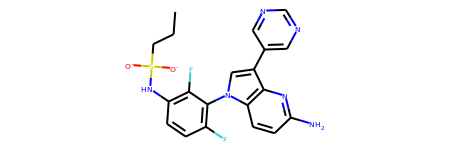

In [108]:
remote.coordinates.to_rdkit(12347, entity="ligand", extension="mol2")

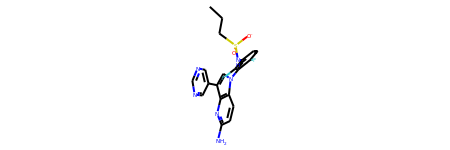

In [109]:
remote.coordinates.to_rdkit(12347, entity="ligand", extension="mol2", compute2d=False)

In [110]:
try:
    remote.coordinates.to_rdkit(12347, entity="ligand", extension="pdb")
except ValueError as e:
    print(e)

Entity ligand is not available or not available remotely.


### ... to `rdkit` molecule (locally)

#### ... from structure KLIFS ID

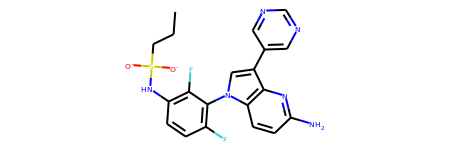

In [111]:
local.coordinates.to_rdkit(12347, entity="ligand", extension="mol2")

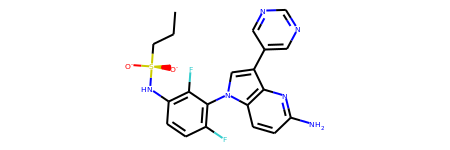

In [112]:
local.coordinates.to_rdkit(12347, entity="ligand", extension="pdb")

#### ... from file

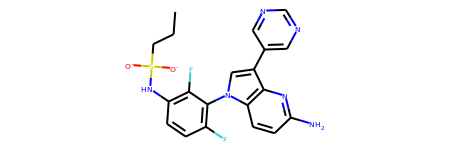

In [113]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/ligand.mol2"
local.coordinates.to_rdkit(filepath)

### ... to _mol2_ file (remotely)

In [114]:
filepath = remote.coordinates.to_mol2(12347, ".")
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN_BRAF_6uuo_chainA_complex.mol2 exists? True


In [115]:
filepath = remote.coordinates.to_mol2(12347, ".", entity="pocket")
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN_BRAF_6uuo_chainA_pocket.mol2 exists? True


In [116]:
filepath = remote.coordinates.to_mol2(12347, ".", entity="pocket", in_dir=True)
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN/BRAF/6uuo_chainA/pocket.mol2 exists? True


In [117]:
try:
    remote.coordinates.to_mol2(12347, ".", entity="bla")
except ValueError as e:
    print(e)

Entity bla is not available or not available remotely.


### ... to _pdb_ file (remotely)

In [118]:
filepath = remote.coordinates.to_pdb(12347, ".")
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN_BRAF_6uuo_chainA_complex.pdb exists? True


In [119]:
try:
    remote.coordinates.to_pdb(12347, ".", entity="ligand")
except ValueError as e:
    print(e)

Entity ligand is not available or not available remotely.
